In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
import time
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [78]:
df = pd.read_csv("nba_data_ready_to_use.csv")
df.shape

(376, 53)

In [79]:
df.head()

,Id,PlayerName,Salary,Age,GP,GS,MP,FG,FGA,FG%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary_normalized,Position_encoded,Team_encoded
0,0,Stephen Curry,48070014,4.697012,5.559490,5.559490,4.730817,2.885846,3.873783,0.413080,...,1.194318,7.8,0.192,7.5,0.1,7.5,4.7,17.688169,2,22
1,1,John Wall,47345760,4.597157,4.697012,1.540963,4.017286,1.845581,2.872770,0.351103,...,0.552317,0.3,0.020,-0.8,-0.4,-1.2,0.1,17.672988,2,29
2,2,Russell Westbrook,47080179,4.697012,6.047664,4.137711,4.442813,2.240429,3.300269,0.371862,...,1.412268,1.9,0.044,0.3,-0.1,0.2,1.2,17.667363,2,34
3,3,LeBron James,44474988,4.882973,5.527074,5.494161,4.768768,3.023395,4.017286,0.418049,...,1.343298,5.6,0.138,5.5,0.6,6.1,4.0,17.610438,1,32
4,4,Kevin Durant,44119845,4.697012,5.248357,5.248357,4.773462,2.924479,3.726367,0.459852,...,1.233077,6.8,0.194,6.0,1.2,7.1,3.9,17.602420,1,6


In [80]:
df.columns

Index(['Id', 'PlayerName', 'Salary', 'Age', 'GP', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'TotalMinutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary_normalized', 'Position_encoded',
       'Team_encoded'],
      dtype='object')

## True predictors selected from this website:

- https://www.bruinsportsanalytics.com/post/nba-ballers 

In [81]:
# true_pred = ['PTS', 'TOV', 'AST', 'VORP', 'PER']
true_pred = df.loc[:, ['PTS', 'TOV', 'AST', 'VORP', 'PER']]
true_pred

,PTS,TOV,AST,VORP,PER
0,4.459352,1.601251,2.316039,4.7,4.144182
1,3.059059,1.343298,2.098648,0.1,3.300269
2,3.521399,1.687259,2.523462,1.2,3.539394
3,4.431709,1.601251,2.405749,4.0,4.131217
4,4.442813,1.630485,2.055642,3.9,4.257079
...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754
372,1.845581,0.486968,0.418049,-0.2,2.778264
373,1.794654,0.418049,0.673768,-0.3,3.172866
374,1.343298,0.184838,0.836976,0.0,2.872770


In [82]:
base_df = pd.concat([true_pred, df.loc[:, ['Salary']]], axis=1)

In [83]:
base_df.head()

,PTS,TOV,AST,VORP,PER,Salary
0,4.459352,1.601251,2.316039,4.7,4.144182,48070014
1,3.059059,1.343298,2.098648,0.1,3.300269,47345760
2,3.521399,1.687259,2.523462,1.2,3.539394,47080179
3,4.431709,1.601251,2.405749,4.0,4.131217,44474988
4,4.442813,1.630485,2.055642,3.9,4.257079,44119845


In [84]:
other_pred_df = df.drop(columns=['PTS', 'TOV', 'AST', 'VORP', 'PER', 'Salary', 'Id', 'PlayerName'])
other_pred_df.head()

,Age,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,Salary_normalized,Position_encoded,Team_encoded
0,4.697012,5.559490,5.559490,4.730817,2.885846,3.873783,0.413080,2.033680,3.059059,0.365228,...,5.8,1.194318,7.8,0.192,7.5,0.1,7.5,17.688169,2,22
1,4.597157,4.697012,1.540963,4.017286,1.845581,2.872770,0.351103,0.730463,1.601251,0.269993,...,-0.4,0.552317,0.3,0.020,-0.8,-0.4,-1.2,17.672988,2,29
2,4.697012,6.047664,4.137711,4.442813,2.240429,3.300269,0.371862,0.836976,1.794654,0.276365,...,-0.6,1.412268,1.9,0.044,0.3,-0.1,0.2,17.667363,2,34
3,4.882973,5.527074,5.494161,4.768768,3.023395,4.017286,0.418049,1.270788,2.423101,0.284283,...,3.2,1.343298,5.6,0.138,5.5,0.6,6.1,17.610438,1,32
4,4.697012,5.248357,5.248357,4.773462,2.924479,3.726367,0.459852,1.194318,2.033680,0.348109,...,4.7,1.233077,6.8,0.194,6.0,1.2,7.1,17.602420,1,6


In [85]:
total_features_df = base_df
total_features_df

,PTS,TOV,AST,VORP,PER,Salary
0,4.459352,1.601251,2.316039,4.7,4.144182,48070014
1,3.059059,1.343298,2.098648,0.1,3.300269,47345760
2,3.521399,1.687259,2.523462,1.2,3.539394,47080179
3,4.431709,1.601251,2.405749,4.0,4.131217,44474988
4,4.442813,1.630485,2.055642,3.9,4.257079,44119845
...,...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754,508891
372,1.845581,0.486968,0.418049,-0.2,2.778264,508891
373,1.794654,0.418049,0.673768,-0.3,3.172866,508891
374,1.343298,0.184838,0.836976,0.0,2.872770,508891


In [86]:
# Iteratively select random columns and concatenate to base_df
for _ in range(5):
    selected_column_name = random.choice(other_pred_df.columns)
    selected_column = pd.DataFrame(other_pred_df[selected_column_name])
    selected_column.columns = [selected_column_name]  # Ensure the column name is retained
    total_features_df = pd.concat([total_features_df, selected_column], axis=1)
    other_pred_df = other_pred_df.drop(columns=selected_column_name)  # Optionally remove the selected column to avoid repeats

In [87]:
total_features_df

,PTS,TOV,AST,VORP,PER,Salary,2P,FT,2P%,FT%,TOV%
0,4.459352,1.601251,2.316039,4.7,4.144182,48070014,2.077294,1.965840,0.472805,0.682432,3.183845
1,3.059059,1.343298,2.098648,0.1,3.300269,47345760,1.571419,1.307510,0.388659,0.540157,3.626773
2,3.521399,1.687259,2.523462,1.2,3.539394,47080179,1.988790,1.478056,0.408805,0.523977,3.734427
3,4.431709,1.601251,2.405749,4.0,4.131217,44474988,2.736065,1.965840,0.473483,0.594913,3.082429
4,4.442813,1.630485,2.055642,3.9,4.257079,44119845,2.648297,2.352532,0.498318,0.684732,3.279669
...,...,...,...,...,...,...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754,508891,1.113384,0.982247,0.510883,0.607175,2.778264
372,1.845581,0.486968,0.418049,-0.2,2.778264,508891,0.673768,0.673768,0.406662,0.587498,3.380344
373,1.794654,0.418049,0.673768,-0.3,3.172866,508891,1.027379,0.486968,0.460537,0.564993,3.279669
374,1.343298,0.184838,0.836976,0.0,2.872770,508891,0.614477,0.184838,0.409518,0.531122,2.539599


## Lasso time

In [88]:
X = total_features_df.drop(['Salary'], axis=1)
y = total_features_df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [89]:
X.head()

,PTS,TOV,AST,VORP,PER,2P,FT,2P%,FT%,TOV%
0,4.459352,1.601251,2.316039,4.7,4.144182,2.077294,1.965840,0.472805,0.682432,3.183845
1,3.059059,1.343298,2.098648,0.1,3.300269,1.571419,1.307510,0.388659,0.540157,3.626773
2,3.521399,1.687259,2.523462,1.2,3.539394,1.988790,1.478056,0.408805,0.523977,3.734427
3,4.431709,1.601251,2.405749,4.0,4.131217,2.736065,1.965840,0.473483,0.594913,3.082429
4,4.442813,1.630485,2.055642,3.9,4.257079,2.648297,2.352532,0.498318,0.684732,3.279669


In [90]:
lasso = LassoCV(cv=5, random_state=8, n_jobs=-1)

lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 24624.34717431224


In [91]:
lasso_coefficients = lasso.coef_
lasso_coefficients

array([  825610.27499857, 12379882.36002528,   668459.19660784,
        3457343.21165373, -2145667.7576914 ,        0.        ,
             -0.        ,        0.        ,       -0.        ,
       -1841092.02723359])

In [92]:
# Print list of new coefficients of all features
lasso_coefficients_df = pd.DataFrame({'Feature': X.columns, 'LassoCV_Coefficient': lasso_coefficients})
lasso_coefficients_df

,Feature,LassoCV_Coefficient
0,PTS,8.256103e+05
1,TOV,1.237988e+07
2,AST,6.684592e+05
3,VORP,3.457343e+06
4,PER,-2.145668e+06
5,2P,0.000000e+00
6,FT,-0.000000e+00
7,2P%,0.000000e+00
8,FT%,-0.000000e+00
9,TOV%,-1.841092e+06


In [93]:
# To avoid taking log of zero or negative, add a small constant (epsilon)
epsilon = 1e-10
logged_lasso_coefficients = np.log(np.abs(lasso_coefficients) + epsilon) * np.sign(lasso_coefficients)

# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': (X.columns),
    'Logged_Lasso_Coefficients': logged_lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Logged_Lasso_Coefficients'] == 0]['Feature_Index']



In [94]:
coefficients_df

,Feature_Index,Logged_Lasso_Coefficients
0,PTS,13.623878
1,TOV,16.331583
2,AST,13.412731
3,VORP,15.056011
4,PER,-14.578961
5,2P,-0.000000
6,FT,-0.000000
7,2P%,-0.000000
8,FT%,-0.000000
9,TOV%,-14.425869


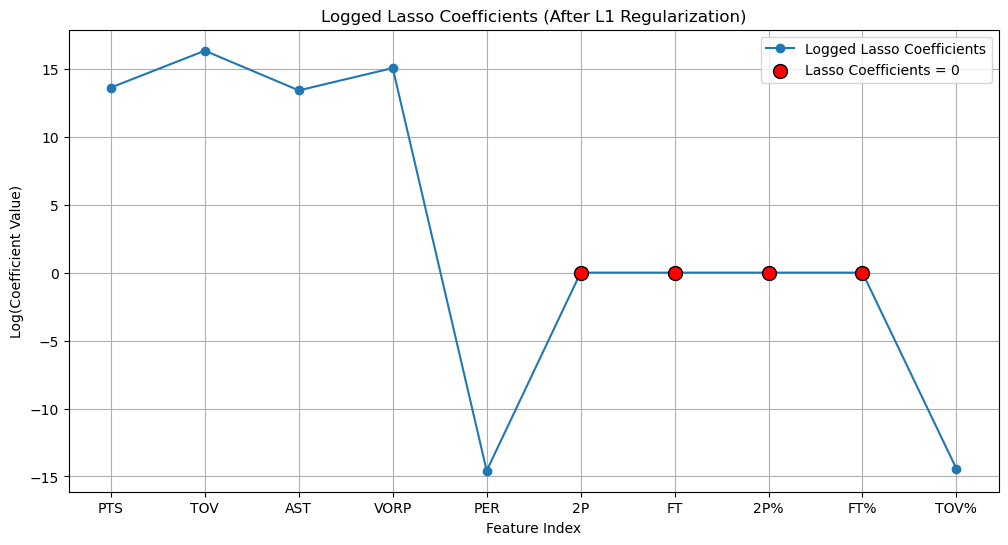

In [95]:
# Plot logged Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Logged_Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Log(Coefficient Value)')
plt.title('Logged Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()